In [41]:
from scipy.optimize import brentq
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime as dt
from scipy.stats import norm
import matplotlib.pyplot as plt

In [43]:
# Datos del activo y opciones
ticker = yf.Ticker('F')
expiry = '2025-11-14'  # expiración fija

# Precios históricos hasta el 2025-10-23 para spot y volatilidad implícita
prices_before = ticker.history(period='2y', end="2025-10-23")['Close']
last_price = float(prices_before.iloc[-1])
margin = 1

# Opciones cercanas al spot
options = ticker.option_chain(expiry).calls
options = options[(options['strike'] >= last_price - margin) & (options['strike'] <= last_price + margin)]


In [58]:
# Parámetros
S_0 = last_price
t_days = (dt.strptime(expiry, '%Y-%m-%d') - dt(2025,10,23)).days + 1
t = t_days / 252  # tiempo en años
r = (1+0.071)**(1/252)-1

print(f"S_0: {S_0}")
print(f"Tiempo hasta expiración (días): {t_days}")
print(f"r diario: {r:.6f}")

# Calculo Volatilidad Implícita
implied_vols = []

for K, market_price in zip(options['strike'], options['lastPrice']):
    def BS(sigma):
        d1 = (np.log(S_0/K) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
        d2 = d1 - sigma*np.sqrt(t)
        c = S_0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
        return c

    def objective(sigma):
        return BS(sigma) - market_price

    try:
        implied_vol = brentq(objective, 1e-6, 5, xtol=1e-6)
    except:
        implied_vol = np.nan

    implied_vols.append({'strike': K, 'implied_vol': implied_vol})

implied_df = pd.DataFrame(implied_vols)

S_0: 12.430000305175781
Tiempo hasta expiración (días): 23
r diario: 0.000272


In [60]:
# Precios desde el 23/oct hasta hoy 3/nov para volatilidad realizada
prices_recent = ticker.history(start="2025-10-23", end="2025-11-03")['Close']

# Timeframes reales posibles (en días)
timeframes = [3, 5, 7]

realized_vols = []

for days in timeframes:
    if days > len(prices_recent):
        print(f"No hay suficientes datos para {days} días, solo hay {len(prices_recent)} días")
        continue
    subset = prices_recent.iloc[:days]
    log_returns = np.log(subset / subset.shift(1)).dropna()
    realized_vol = np.sqrt(252) * log_returns.std()
    realized_vols.append({'days': days, 'realized_vol': float(realized_vol)})

realized_df = pd.DataFrame(realized_vols)

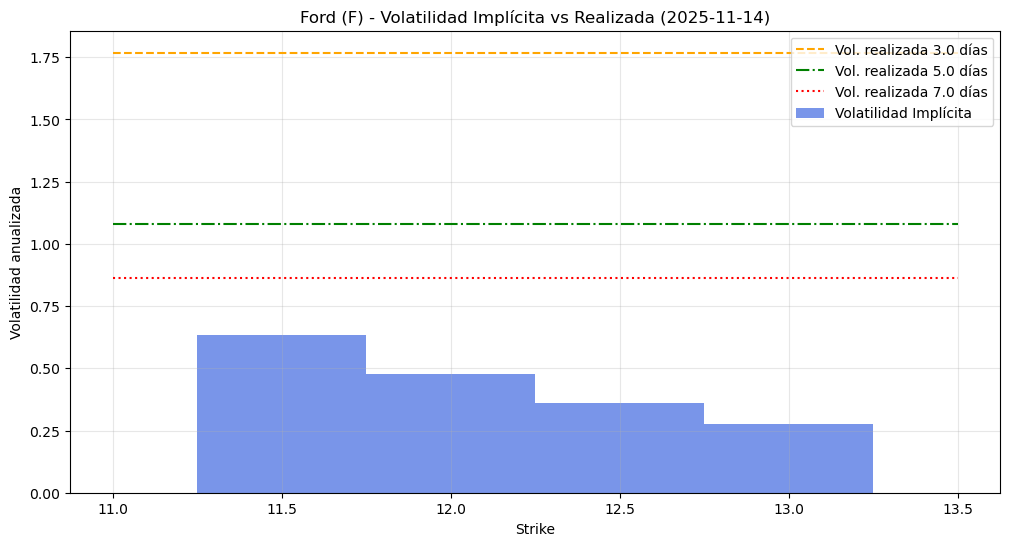

In [62]:
# Gráfica comparativa
plt.figure(figsize=(12,6))

plt.bar(implied_df['strike'], implied_df['implied_vol'], width=0.5, alpha=0.7, label='Volatilidad Implícita', color='royalblue')

colors = ['orange', 'green', 'red']
linestyles = ['--', '-.', ':']

for idx, row in realized_df.iterrows():
    plt.hlines(y=row['realized_vol'], xmin=implied_df['strike'].min()-0.5,
               xmax=implied_df['strike'].max()+0.5,
               colors=colors[idx],
               linestyles=linestyles[idx],
               label=f"Vol. realizada {row['days']} días")

plt.xlabel('Strike')
plt.ylabel('Volatilidad anualizada')
plt.title(f'Ford (F) - Volatilidad Implícita vs Realizada ({expiry})')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Conclusiones sobre la gráfica de volatilidad implícita vs volatilidad realizada**

1.- **Volatilidad implícita decreciente con el strike:**

- Observamos que a medida que el precio de ejercicio (strike) aumenta, la volatilidad implícita tiende a disminuir.

- Esto suele reflejar una "curva de volatilidad" con pendiente negativa para estas opciones cercanas al precio spot.

- Puede indicar que el mercado percibe menor riesgo o menor probabilidad de movimientos bruscos al alza del activo.


2.- **Volatilidad realizada vs volatilidad implícita y efecto del tiempo:**

- Para los distintos períodos de volatilidad realizada (3, 5 y 7 días), se ve que la volatilidad realizada es mayor que la volatilidad implícita estimada a vencimiento.

- A medida que el periodo de volatilidad realizada aumenta (de 3 a 7 días), las líneas de volatilidad realizada se acercan un poco más al nivel de la volatilidad implícita.

- Esto es razonable, ya que la volatilidad realizada en ventanas más largas tiende a ser una mejor estimación de la volatilidad futura que el mercado está anticipando.

- Además, la volatilidad implícita está calculada para un vencimiento hasta el 14 de nobimebre, por lo que se espera que la volatilidad realizada se aproxime más a esa medida cuando la ventana aumenta y se acerca al vencimiento.

3.- **Diferencia entre volatilidad implícita y realizada:**

- El hecho de que la volatilidad implícita sea más baja que la realizada puede indicar que el mercado está anticipando una disminución de la volatilidad futura con respecto a la volatilidad reciente.

- Esto también puede reflejar que los inversores están valorando una menor incertidumbre para los próximos días o que el mercado ya descontó movimientos fuertes recientes.

- También es común que la volatilidad implícita incluya una prima de riesgo, y que a veces esta prima varíe dependiendo del sentimiento del mercado.

4.- **Reflexión sobre la utilidad práctica:**

- Comparar volatilidad implícita y realizada en diferentes ventanas permite entender si las opciones están caras o baratas en términos de riesgo esperado.

- Si la volatilidad implícita es consistentemente menor que la realizada, puede indicar oportunidades para estrategias que se beneficien de una posible subida en la volatilidad.

- La forma decreciente de la volatilidad implícita con el strike sugiere también que la demanda por opciones "in the money" o "out the money" puede ser asimétrica.